In [1]:
# Common stuff

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import seaborn as sns
import cv2

In [2]:
# Solution is very simple, just use better conv layers, e.g. ResNet50

import numpy as np
import keras
import gc
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

IMG_SIZE = (224, 224)

Using TensorFlow backend.


In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)
    array = img_to_array(img)
    return preprocess_input(array)
def fit_generator(files, batch_size=8):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            gc.collect()
            yield (x, y)
def predict_generator(files):    
    while True:        
        for path in files:            
            yield np.array([load_image(path)])

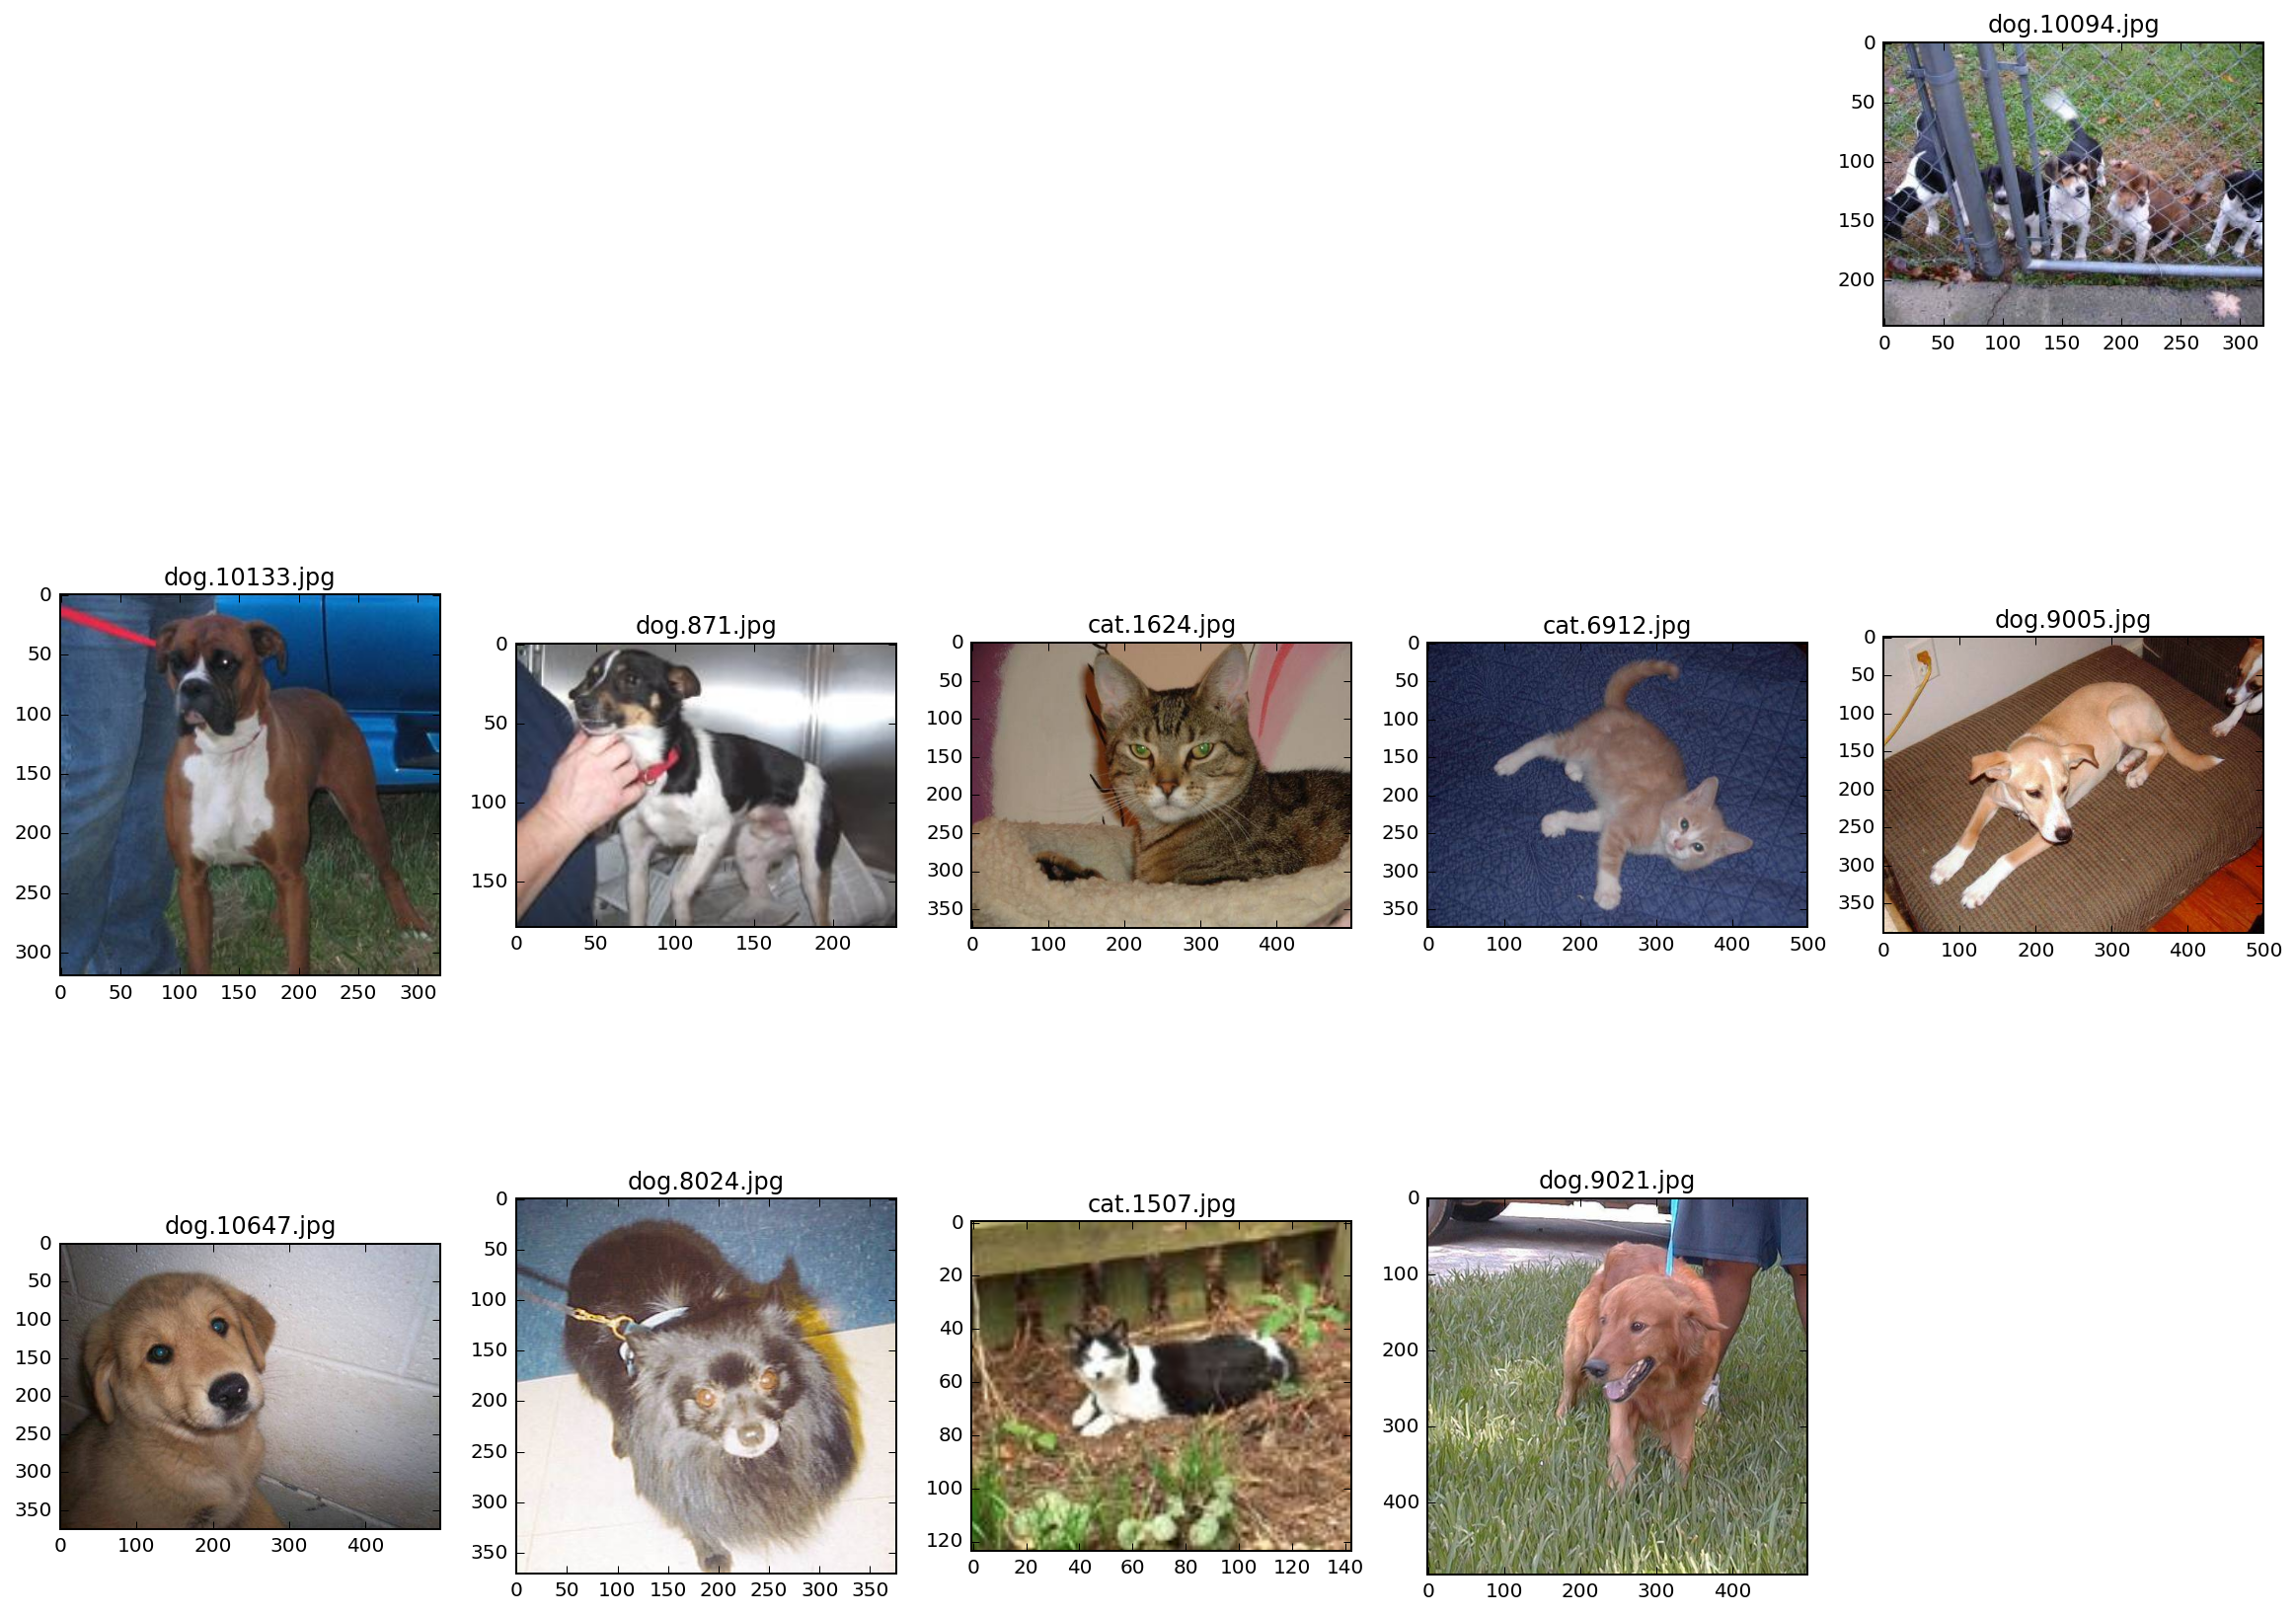

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

In [5]:
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [6]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,
                activation='sigmoid',
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

shuffle(train_files)

train_val_split = 100

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

model.fit_generator(fit_generator(train_files[train_val_split:]),
        steps_per_epoch=10,
        epochs=50,
        validation_data=validation_data,
        use_multiprocessing=False)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0        

Epoch 1/50
10/10 [==============================] - 6s 633ms/step - loss: 0.7016 - acc: 0.5750 - val_loss: 0.6155 - val_acc: 0.6800
Epoch 2/50
10/10 [==============================] - 4s 416ms/step - loss: 0.5685 - acc: 0.7875 - val_loss: 0.4559 - val_acc: 0.7300
Epoch 3/50
10/10 [==============================] - 4s 409ms/step - loss: 0.3561 - acc: 0.8375 - val_loss: 0.4046 - val_acc: 0.8100
Epoch 4/50
10/10 [==============================] - 4s 402ms/step - loss: 0.3245 - acc: 0.8625 - val_loss: 0.2725 - val_acc: 0.8700
Epoch 5/50
10/10 [==============================] - 4s 404ms/step - loss: 0.3643 - acc: 0.8250 - val_loss: 0.2280 - val_acc: 0.9300
Epoch 6/50
10/10 [==============================] - 4s 419ms/step - loss: 0.2640 - acc: 0.8625 - val_loss: 0.2074 - val_acc: 0.9300
Epoch 7/50
10/10 [==============================] - 4s 428ms/step - loss: 0.2777 - acc: 0.9000 - val_loss: 0.1652 - val_acc: 0.9600
Epoch 8/50
10/10 [==============================] - 4s 413ms/step - loss: 0.

In [7]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), use_multiprocessing=False)

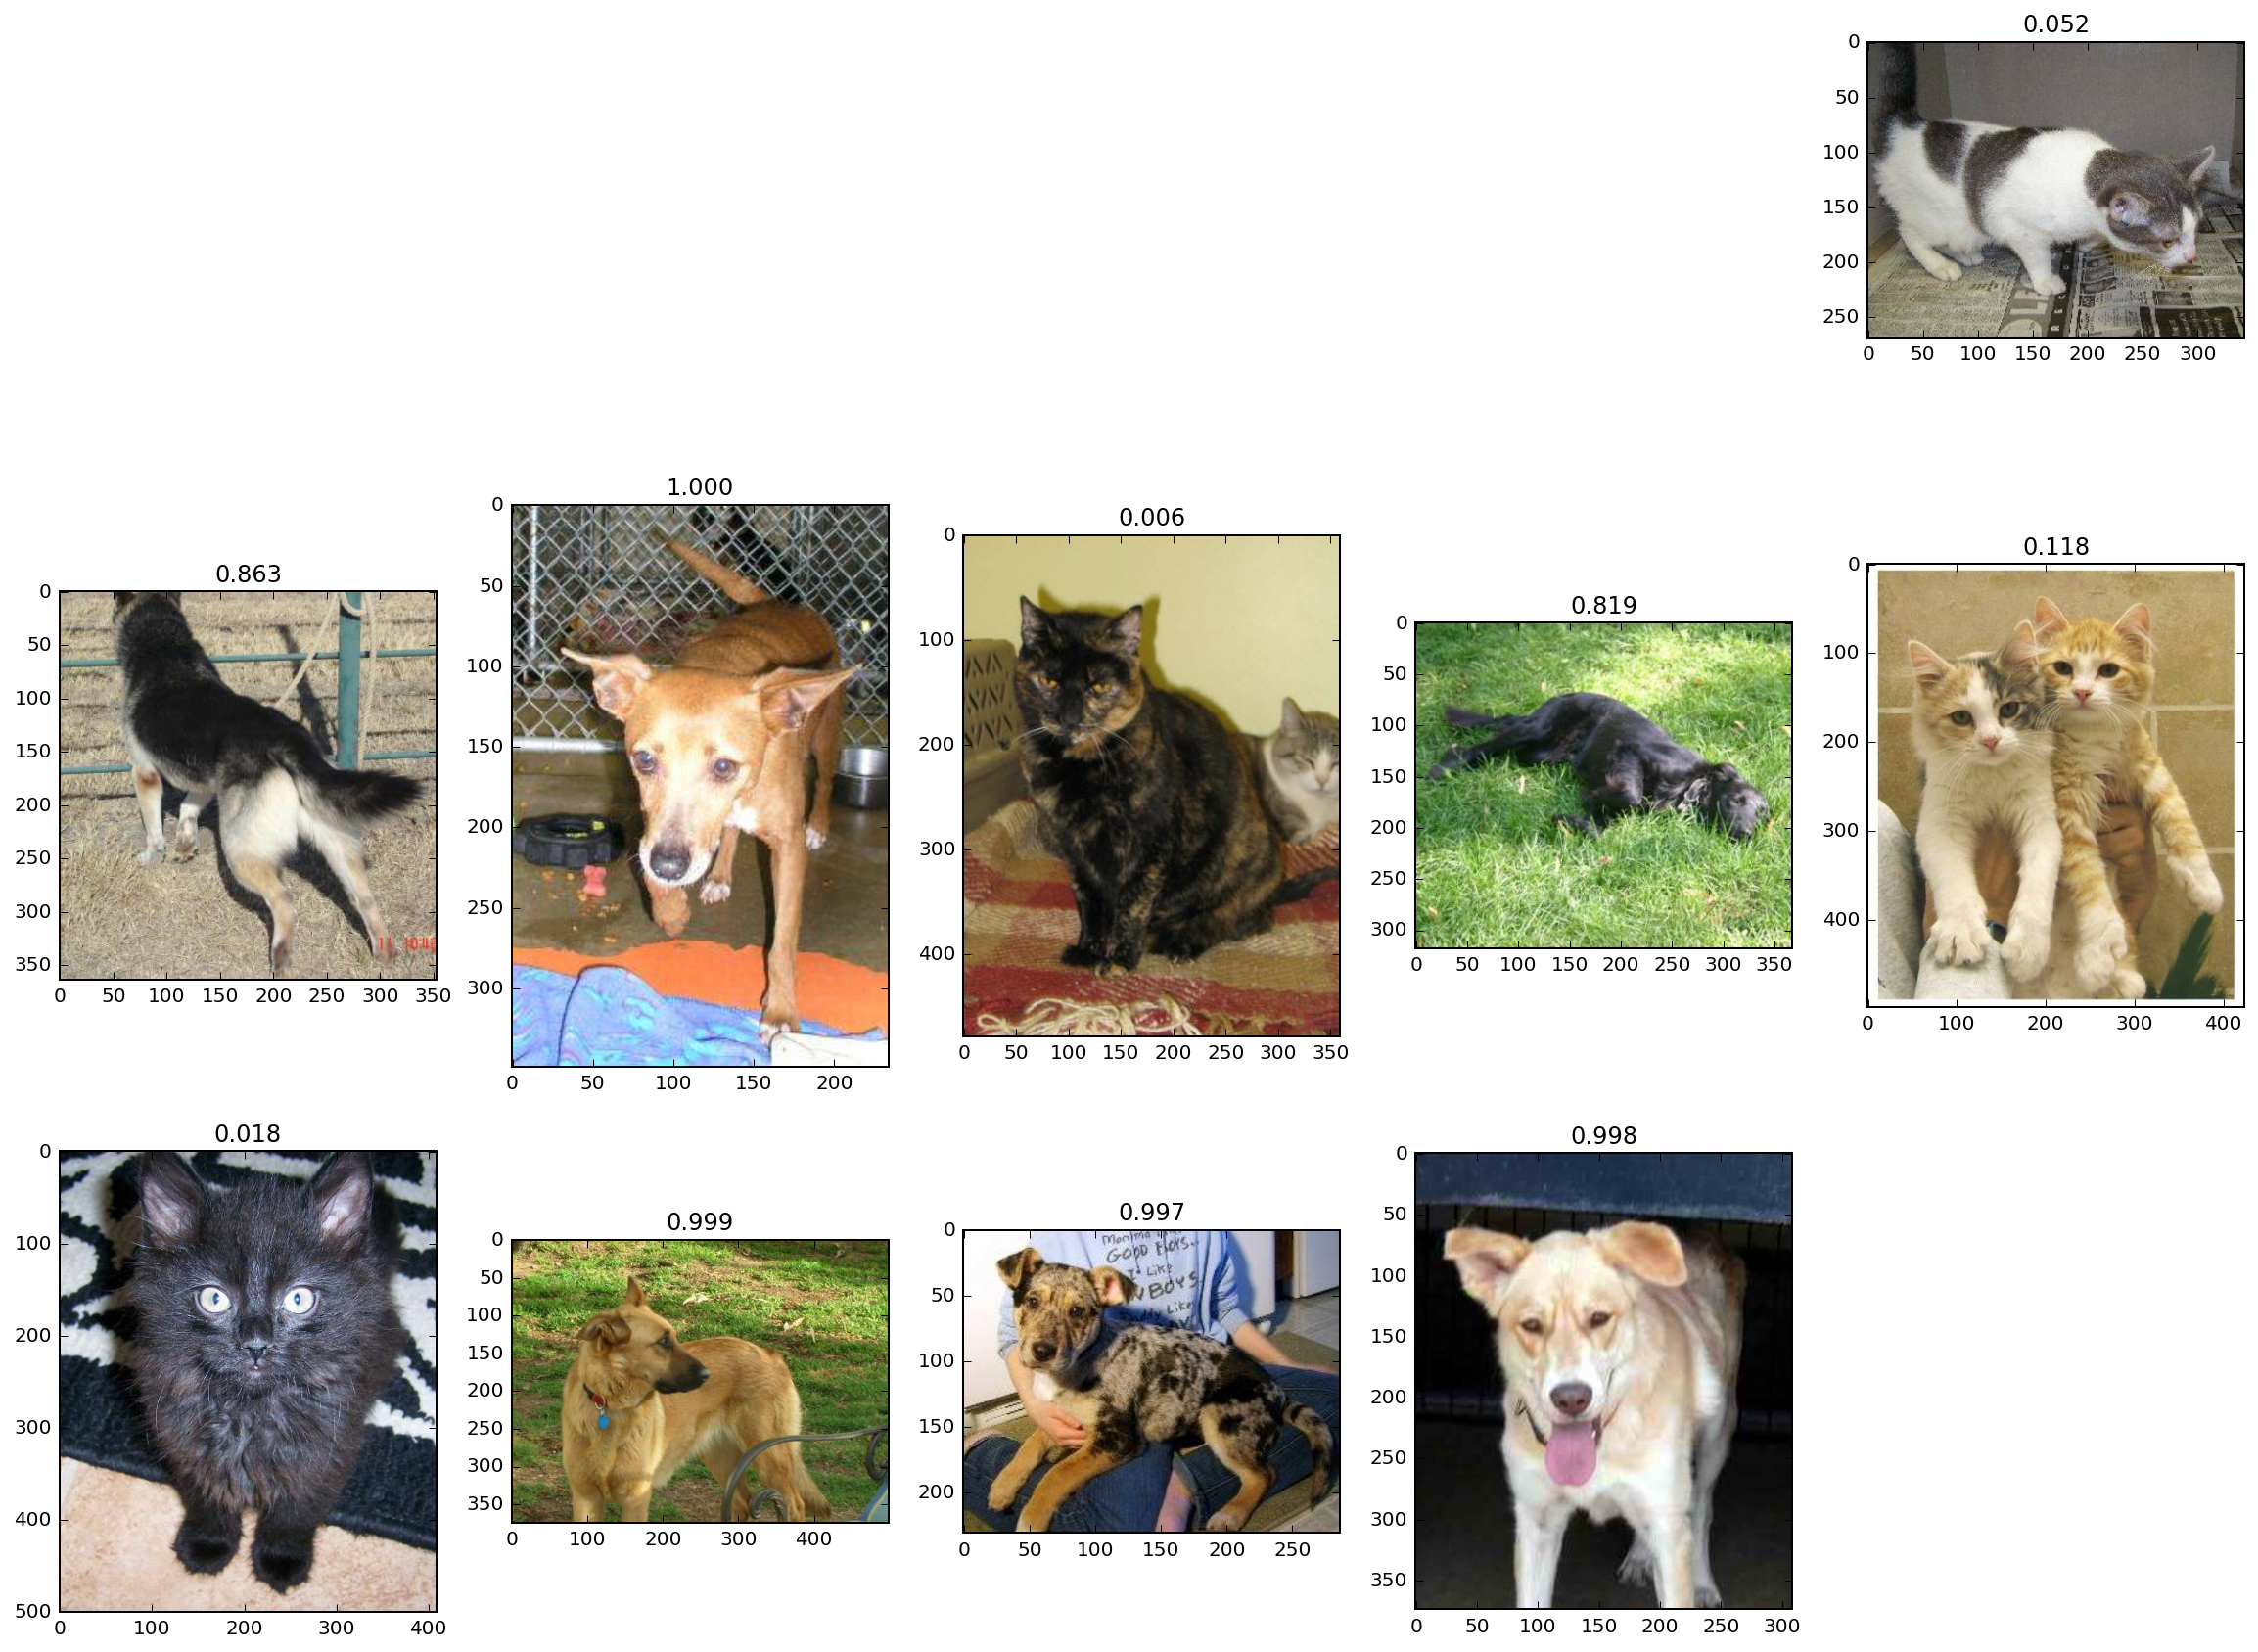

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [9]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

Here's what we got:

![title](screen1.png)